# Hello PyTorch EfficientNet classifier for CIFAR-10 Image Dataset

In [4]:
# Prerequisites
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("Python Version: ", sys.version)

import torch
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
import torch.nn.functional as F

from tqdm import tqdm


Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]


Check for Cuda availability

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


### Data Preparation

In [6]:
# Normalize and transform the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset, download if not present
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# define the data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)


### Define EfficientNet Architecture

In [7]:
class MBConv(nn.Module):
    """Mobile Inverted Residual Bottleneck Block."""

    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 expand_ratio: int, 
                 stride: int, 
                 kernel: int):
        """
        Parameters:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        expand_ratio (int): Ratio to expand channels before depthwise conv.
        stride (int): Stride factor for depthwise conv.
        kernel (int): Kernel size for depthwise conv.
        """
        super(MBConv, self).__init__()

        # hidden_dim refers to the number of channels after expansion.
        hidden_dim = in_channels * expand_ratio

        # use_residual determines whether or not to use residual connection based on input and output channels.
        self.use_residual = in_channels == out_channels and stride == 1

        layers = []

        # Expansion phase: only applies when expand_ratio != 1
        if expand_ratio != 1:
            layers += [
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU() # Swish activation function
            ]

        # Depthwise convolution phase
        layers += [
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel, stride=stride, padding=kernel//2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU() # Swish activation function
        ]

        # Output phase
        layers += [
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        ]

        # Sequentially execute layers
        self.block = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of MBConv block.

        Parameters:
        x (Tensor): Input tensor.

        Returns:
        Tensor: Output tensor.
        """
        if self.use_residual:
            return x + self.block(x)
        else:
            return self.block(x)

class EfficientNetB0(nn.Module):
    """EfficientNetB0 model."""

    def __init__(self, num_classes: int = 1000):
        """
        Parameters:
        num_classes (int): Number of output classes. Default: 1000
        """
        super(EfficientNetB0, self).__init__()

        # The first convolutional layer (stem)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU() # Swish activation function
        )

        # The main body consists of MBConv blocks
        self.blocks = nn.Sequential(
            MBConv(32, 16, expand_ratio=1, stride=1, kernel=3),
            MBConv(16, 24, expand_ratio=6, stride=2, kernel=3),
            MBConv(24, 24, expand_ratio=6, stride=1, kernel=3),
            MBConv(24, 40, expand_ratio=6, stride=2, kernel=5),
            MBConv(40, 40, expand_ratio=6, stride=1, kernel=5),
            MBConv(40, 80, expand_ratio=6, stride=2, kernel=3),
            MBConv(80, 80, expand_ratio=6, stride=1, kernel=3),
            MBConv(80, 112, expand_ratio=6, stride=1, kernel=5),
            MBConv(112, 192, expand_ratio=6, stride=2, kernel=5),
            MBConv(192, 320, expand_ratio=6, stride=1, kernel=3),
        )


        # The final layers (head)
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU(), # Swish activation function
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of EfficientNetB0.

        Parameters:
        x (Tensor): Input tensor.

        Returns:
        Tensor: Output tensor.
        """
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x


In [ ]:
# Check Model structure
print(EfficientNetB0(10))

EfficientNetB0(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (blocks): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MBConv(
      (block): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding

### Instantiate EfficientNet

In [9]:
# Instantiate the model
model = EfficientNetB0(num_classes=10).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


### Train EfficientNet

In [7]:
nr_epochs = 50

prog_bar = tqdm(range(nr_epochs), desc="Training Progress", unit="epoch")

# Training loop
for epoch in range(nr_epochs):
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        log_probs = model(images)
        loss = criterion(log_probs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Update progress bar
    prog_bar.set_postfix(loss=running_loss)
    prog_bar.update(1)

# Close the progress bar
prog_bar.close()    

Training Progress: 100%|██████████| 50/50 [10:29<00:00, 12.59s/epoch, loss=8.2]   


### Save and Load the model

In [ ]:
# Save the model
torch.save(model.state_dict(), "./saved_models/efficientnet_cifar10.pth")

In [ ]:
# Load the model for inference
model.load_state_dict(torch.load("./saved_models/efficientnet_cifar10.pth"))

<All keys matched successfully>

In [10]:
model = model.to(device)

### Run Inference and Evaluate Model

In [11]:
nr_correct = 0
nr_total = 0

with torch.no_grad():   # Do not calculate gradients
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        # Inference
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        nr_total += labels.size(0)
        nr_correct += (predicted == labels).sum().item()

    print("Accuracy of 10000 test images: ", 100 * nr_correct / nr_total, "%")


Accuracy of 10000 test images:  83.88 %


### Analyze Results

In [12]:
# Helper function to display image
def disp_img(img):
    img = img*0.5 + 0.5    # unnormalize
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))   # Transpose the image to (H, W, C)
    plt.xticks([])
    plt.yticks([])


# Helper function to display image and predictions 
def disp_img_pred(imgages, labels, predicted, classes, nr_images=10):
    plt.figure(figsize=(15, 10))
    for i in range(nr_images):
        ax = plt.subplot(2, 5, i+1)
        disp_img(imgages[i])
        ax.set_title(f"Actual: {classes[labels[i]]}, Pred: {classes[predicted[i]]}")
        plt.tight_layout()

    plt.show()
    

Display 10 images

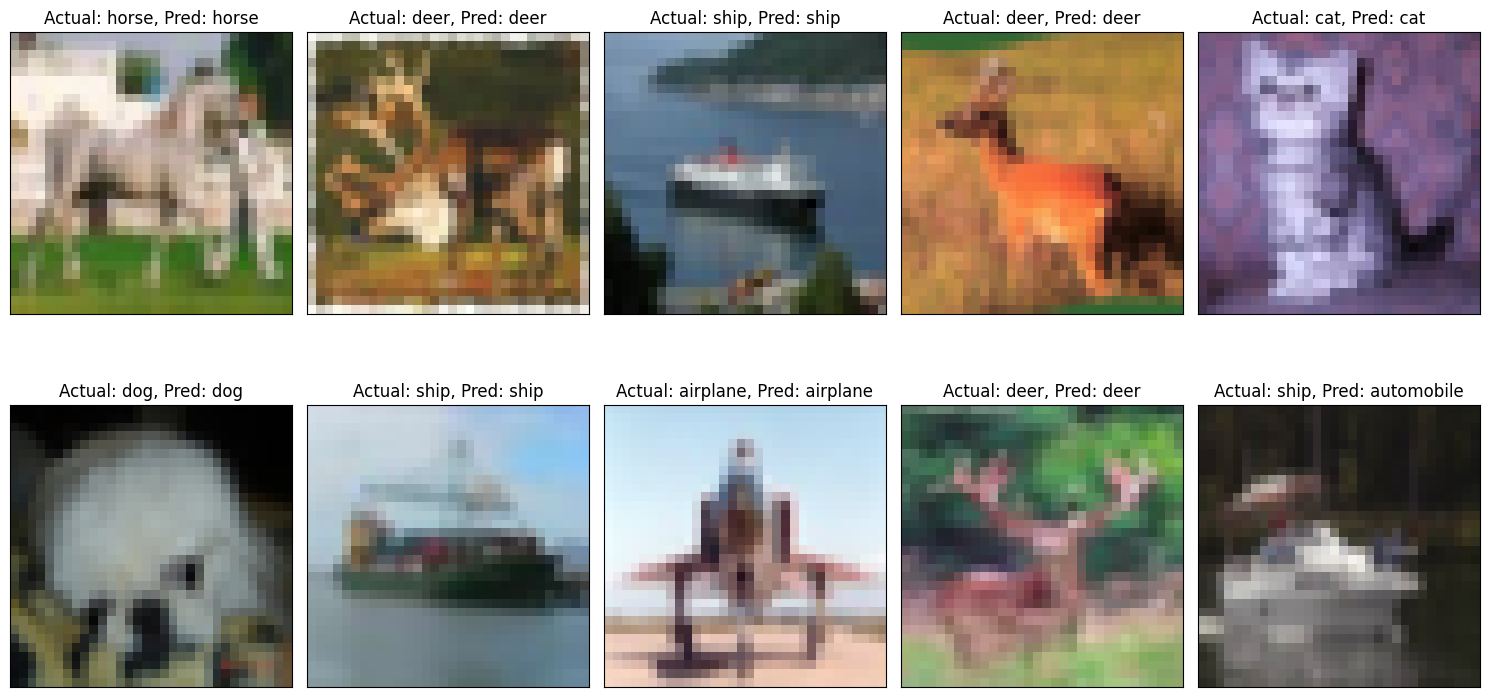

In [13]:
images = images.to("cpu")
labels = labels.to("cpu")

classes = ["airplane", "automobile", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck"]

disp_img_pred(images, labels, predicted, classes, nr_images=10)


Analyze performance per class

In [14]:
nr_classes = 10
correct_per_class = [0] * nr_classes
total_per_class = [0] * nr_classes
true_positive = [0] * nr_classes
false_positive = [0] * nr_classes
false_negative = [0] * nr_classes

# Run Evaluation Loop   
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

    for label, prediction in zip(labels, predicted):
        if label == prediction:
            correct_per_class[label] += 1
            true_positive[label] += 1
        else:
            false_positive[prediction] += 1
            false_negative[label] += 1

        total_per_class[label] += 1


accuracy_per_class = [100*tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(true_positive, false_positive)]
recall_per_class = [100*tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(true_positive, false_negative)]
overall_accuracy = 100 * sum(correct_per_class) / sum(total_per_class)

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print("Accuracy per Class:")
for i in range(nr_classes):
    print(f"Class {classes[i]}: Accuracy: {accuracy_per_class[i]:.2f}%,"
          f" Recall: {recall_per_class[i]:.2f}%")
    

Overall Accuracy: 87.50%
Accuracy per Class:
Class airplane: Accuracy: 0.00%, Recall: 0.00%
Class automobile: Accuracy: 100.00%, Recall: 100.00%
Class bird: Accuracy: 66.67%, Recall: 100.00%
Class cat: Accuracy: 100.00%, Recall: 100.00%
Class deer: Accuracy: 0.00%, Recall: 0.00%
Class dog: Accuracy: 50.00%, Recall: 50.00%
Class frog: Accuracy: 0.00%, Recall: 0.00%
Class horse: Accuracy: 100.00%, Recall: 100.00%
Class ship: Accuracy: 0.00%, Recall: 0.00%
Class truck: Accuracy: 100.00%, Recall: 100.00%
